In [3]:
import struct
from functools import reduce
from dtw import *
import crepe
import rosbag
import librosa
import numpy as np
import pretty_midi
import rospy

In [4]:
def hz_to_note(hz):
	return pretty_midi.note_number_to_name(pretty_midi.hz_to_note_number(hz))

def note_to_pm_id(note_name):
	return pretty_midi.note_name_to_number(note_name)

def pm_id_to_note(pm_id):
	return pretty_midi.note_number_to_name(pm_id)

def note_to_hz(note):
	return pretty_midi.note_number_to_hz(pretty_midi.note_name_to_number(note))

In [5]:
class OnsetDetection:
	def __init__(self):
		self.first_input = True
		self.notes = []
		# other parameters
		self.last_seq_id = 0

		self.init_instrument_config()
		self.init_audio_config()
		self.init_detection_config()

		# the buffer to read audio raw data from ros topic
		self.buffer = np.array([0.0] * self.sr, dtype=float)

	def init_instrument_config(self):
		"""
			The configuration of the instrument.

			And some examples of the configuration of different instruments:
			# harp
			self.fmin_note = "C4"
			self.fmax_note = "C6"
			self.semitones = 62

			# guzheng
			self.fmin_note = "C2"
			self.fmax_note = "C8"
			self.semitones = 84
		"""

		# marimba
		self.fmin_note = "C4"  # C4 pm_id=60
		self.fmin_note_id = note_to_pm_id(self.fmin_note)
		self.fmax_note = "C7"  # C7 pm_id=96
		self.fmax_note_id = note_to_pm_id(self.fmax_note)
		self.semitones = 36 + 24  # 60   36 for 4-6 octives, 24 for overtones for two octives

		# convert the western notation to the corresponding frequency
		self.fmin = note_to_hz(self.fmin_note)
		self.fmax = note_to_hz(self.fmax_note)
		rospy.logdebug("Instrument configuration initialized.")

	def init_audio_config(self):
		"""
			The configuration of the audio signal
		"""
		self.sr = 44100
		self.hop_length = 512  # each hop equal to one pixel in spectrum
		self.pixels_per_sec = self.sr / self.hop_length  # careful, it is float for further precise calculation.
		rospy.logdebug(f"Audio configuration initialized.")

	def init_detection_config(self):
		"""
			confidence threshold for note classification(crepe)
		"""
		# For onset detection
		self.window_t = 1
		self.window_overlap_t = 0.5
		self.window_num = int(self.sr * self.window_t)
		self.window_overlap_num = int(self.sr * self.window_overlap_t)
		self.confidence_threshold = 0.7
		self.amplitude_ref = 10.0
		self.windows_for_classification = 0.1  # using 0.1 sec data after onset time for note classification
		# preload model to not block the callback on first message
		# capacities: 'tiny', 'small', 'medium', 'large', 'full'
		self.crepe_model = "full"  # choose the crepe model type for music note classification
		rospy.logdebug(f"Loading crepe {self.crepe_model}-model...")
		crepe.core.build_and_load_model(self.crepe_model)
		rospy.logdebug(f"Crepe {self.crepe_model}-model loaded.")
		rospy.logdebug("Detection configuration initialized.")
		self.delta = 1.5

	def reset(self):
		# audio buffer
		self.buffer_time = None
		self.buffer = np.array([], dtype=float)

	def process_ros_bag(self, path_bag):
		bag = rosbag.Bag(path_bag, 'r')
		for topic, msg, t in bag.read_messages(topics=['/audio_node/audio_stamped']):
			# the way to decode the data from ros topic
			msg_data = np.array(struct.unpack(f"{int(len(msg.audio.data) / 2)}h", bytes(msg.audio.data)), dtype=float)
			self.buffer = np.concatenate([
				self.buffer,
				msg_data
			])
			# make sure buffer is full, which is 1 sec new data and 1 sec old data. aka. 1 sec per update of cqt.
			# aggregate buffer until window+2*overlaps are full, like [0.5 Sec Overlap | 1 Sec window | 0.5 Sec Overlap]
			if self.buffer.shape[0] >= self.window_num + 2 * self.window_overlap_num:
				self.audio_process()
				self.buffer = self.buffer[self.window_num:]
		bag.close()
		return self.notes


	# the most important function for signal processing logic
	# 0.5+ sec delay for detection, detect for each 1 sec.
	def audio_process(self):
		onsets_cqt_time_list = self.onset_detection()
		# filter out the onset in the overlap windows, to keep the long tail inside
		# the whole windows include 0.5 sec overlap at both end, the target windows is only 1 sec at the middle.
		def in_window(o):
			# only detect the onset inside the target windows, to make sure the long tail can be included.
			return (o >= self.window_overlap_t and o < self.window_overlap_t + self.window_t)

		onsets_in_windows = [o for o in onsets_cqt_time_list if in_window(o)]

		# since the onset are extracted, then we need to pass them through the classification model to get note label.
		winners_raw_idx = []
		winner_onsets = []
		durations = []
		default_duration = 0.5
		# publish events and plot visualization
		for onset in onsets_in_windows:
			fundamental_frequency, confidence, winner_raw_idx, winner_pm_idx = self.onset_classification(onset)
			if winner_raw_idx is not None:
				# find the y-position of onset in spectrum
				winners_raw_idx.append(winner_raw_idx)  # ys
				winner_onsets.append(onset)  # xs
				durations.append(default_duration)

				note = hz_to_note(fundamental_frequency)
				self.notes.append(note)
				rospy.logdebug(
					f"Onset detection"
					f"[note:{note}, "
					f"confidence:{confidence:.4f}]"
				)

	def onset_detection(self,pre_max=5,post_max=2,pre_avg=5,post_avg=2,wait=10):
		"""
			constant q transform with 60 half-tones from C4,
			in theory we only need notes from C4-C7, but in practice tuning
			is often too low and harmonics are needed above C6,
			therefore we use 60 semitones include 2 octaves overtone.
		"""
		cqt = self.cqt()  # cqt ndarrary  (60,173)
		onset_env_cqt = librosa.onset.onset_strength(sr=self.sr, S=librosa.amplitude_to_db(cqt, ref=self.amplitude_ref))
		# detect when the onset(peak) happened within 2 sec cqt with shape (60,173)
		'''
		A sample n is selected as an peak if the corresponding x[n] fulfills the following three conditions:
			- x[n] == max(x[n - pre_max:n + post_max])  # the maximum in the neighborhood
			- x[n] >= mean(x[n - pre_avg:n + post_avg]) + delta  # the value is above local mean
			- n - previous_n > wait  # enforce a distance of at least wait samples
		'''
		onsets_cqt_time_list = librosa.onset.onset_detect(
			y=self.buffer,
			sr=self.sr,
			hop_length=self.hop_length,
			onset_envelope=onset_env_cqt,
			units="time",
			backtrack=False,
			normalize=False,
			pre_max=pre_max,  # number of samples before n over which max is computed
			post_max=post_max,  # number of samples after n over which max is computed
			pre_avg=pre_avg,  # number of samples before n over which mean is computed
			post_avg=post_avg,  # number of samples after n over which mean is computed
			delta=self.delta,  # threshold offset for mean
			wait=wait,  # number of samples to wait after picking a peak
		)
		return onsets_cqt_time_list

	def setup_parms(self, amplitude_ref, delta):
		self.amplitude_ref = amplitude_ref
		self.delta = delta

	def onset_classification(self, onset):
		"""
			input: onset, a float value from 0 to 1, denote the percentage position of 1 sec
			output:
				-   winner_freq: the freq of the winner signal
				-   max(buckets[winner]): the confidence
				-   winner_idx_in_spec: the idx in spec along y-axis
				-   winner_pm_idx: the note id in the pretty_midi
		"""
		# using 0.1 sec windows data for classification
		prediction_averaging_window = (
				self.windows_for_classification * self.sr
		)
		# extract the data from onset time until 0.1 sec later
		excerpt = self.buffer[int(onset * self.sr):int(onset * self.sr + prediction_averaging_window)]
		# neuron nets for onset classification
		time, freq, confidence, _ = crepe.predict(
			excerpt,
			self.sr,
			viterbi=True,
			model_capacity=self.crepe_model,
			verbose=0
		)

		# filter out the onset, which confidence lower that threshold and note beyond range(C4-C7)
		confidence_mask = confidence > self.confidence_threshold
		freq_mask = (freq >= self.fmin) & (freq <= self.fmax)
		mask = confidence_mask & freq_mask
		filtered_freq = freq[mask]
		filtered_confidence = confidence[mask]

		if len(filtered_freq) > 0:
			buckets = {}
			for f, c in zip(filtered_freq, filtered_confidence):
				note = hz_to_note(f)
				buckets[note] = buckets.get(note, []) + [c]

			def add_confidence(note):
				return reduce(lambda x, y: x + y, buckets.get(note))

			winner = max(buckets, key=lambda a: add_confidence(a))
			winner_freq = note_to_hz(winner)
			winner_pm_idx = note_to_pm_id(winner)
			winner_raw_idx_in_spec = note_to_pm_id(winner) - self.fmin_note_id
			confidence = max(buckets[winner])
			return winner_freq, confidence, winner_raw_idx_in_spec, winner_pm_idx
		else:
			return 0.0, 0.0, None, None

	def cqt(self):
		"""
			The function for constant Q transform
			input: self.buffer
			output: ndarrary with shape (60,173) by default
		"""
		cqt = np.abs(
			librosa.cqt(
				y=self.buffer,
				sr=self.sr,
				hop_length=self.hop_length,
				fmin=self.fmin,
				n_bins=self.semitones,
			)
		)
		return cqt

In [6]:
gt = ['C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4','A#4', 'B4',
      'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'A#5', 'B5',
      'C6', 'C#6', 'D6', 'D#6', 'E6', 'F6', 'F#6', 'G6', 'G#6', 'A6', 'A#6', 'B6',
      ]

In [7]:
detector = OnsetDetection()
bag_path = "./2023-10-16-15-20-18.bag"
deltas = [0.3,0.5,0.7,1.0,1.5,2.0,2.5,3,3.5,4]
amplitude_refs = [0,5,10,15,20,25,30,35,40,45]


2023-10-17 12:46:25.126703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:46:26.519213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-17 12:46:29.442739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 12:46:29.518020: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

In [8]:
def precise(pr,gt):
    pr = np.asarray(pr)
    gt = np.asarray(gt)
    hitted = np.intersect1d(pr,gt).shape[0]

    return  hitted/max(pr.shape[0],gt.shape[0])

In [9]:
scores_2d = []
for delta in deltas:
    score_1d = []
    for amplitude_ref in amplitude_refs:
        detector.setup_parms(amplitude_ref=amplitude_ref,delta=delta)
        pr = detector.process_ros_bag(bag_path)
        detector.notes = []
        score = precise(pr,gt)
        print(f"delta:{delta}, ampref:{amplitude_ref}: precise:{score}")
        score_1d.append(score)
    scores_2d.append(score_1d)


/home/wang/workspace/marimbabot_ws/env_this/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==44.0.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


delta:0.3, ampref:0: precise:0.4
delta:0.3, ampref:5: precise:0.4186046511627907
delta:0.3, ampref:10: precise:0.3763440860215054
delta:0.3, ampref:15: precise:0.37894736842105264
delta:0.3, ampref:20: precise:0.3956043956043956
delta:0.3, ampref:25: precise:0.4
delta:0.3, ampref:30: precise:0.39325842696629215
delta:0.3, ampref:35: precise:0.4044943820224719
delta:0.3, ampref:40: precise:0.4090909090909091
delta:0.3, ampref:45: precise:0.375
delta:0.5, ampref:0: precise:0.43373493975903615
delta:0.5, ampref:5: precise:0.4
delta:0.5, ampref:10: precise:0.42857142857142855
delta:0.5, ampref:15: precise:0.38461538461538464
delta:0.5, ampref:20: precise:0.4235294117647059
delta:0.5, ampref:25: precise:0.42857142857142855
delta:0.5, ampref:30: precise:0.4
delta:0.5, ampref:35: precise:0.41379310344827586
delta:0.5, ampref:40: precise:0.3870967741935484
delta:0.5, ampref:45: precise:0.41379310344827586
delta:0.7, ampref:0: precise:0.5
delta:0.7, ampref:5: precise:0.4430379746835443
delta:0.

In [10]:
import  matplotlib.pyplot as plt

In [11]:
scores_2d = np.asarray(scores_2d)

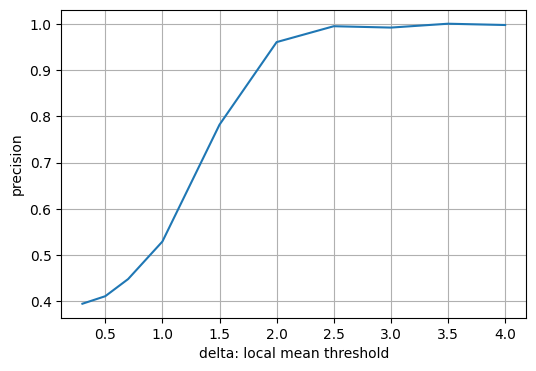

In [23]:
x = np.asarray(deltas)
y = np.mean(scores_2d,axis=1)
plt.figure(figsize=(6,4))
plt.plot(x,y,'-')
plt.grid()
plt.ylabel("precision")
plt.xlabel("delta: local mean threshold")
plt.savefig("./delta.pdf", format="pdf", bbox_inches="tight")
plt.show()

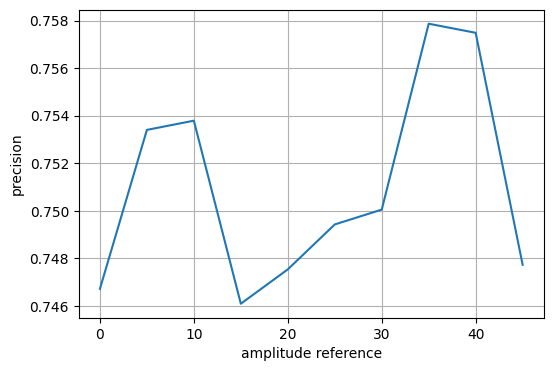

In [24]:
x = np.asarray(amplitude_refs)
y = np.mean(scores_2d,axis=0)
plt.figure(figsize=(6,4))
plt.plot(x,y,'-')
plt.ylabel("precision")
plt.xlabel("amplitude reference")
plt.grid()
plt.savefig("./amp_ref.pdf", format="pdf", bbox_inches="tight")
plt.show()